## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from datetime import datetime
import seaborn as sns
import math
import pickle
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.regularizers import l1_l2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define the functions to be used 

In [ ]:
from statistics import stdev

def Average(data):
    return sum(data) / len(data)

# Z-Scores
def normalize_series(data, mean, std):
    data = data - mean
    data = data / std
    return data

def inverse_normalize_series(data, mean, std):
    data = data * std
    data = data + mean
    return data

# # Min-Max
# def normalize_series(data, min, max):
#     data = data - min
#     data = data / max
#     return data

# def inverse_normalize_series(data, min, max):
#     data = data * max
#     data = data + min
#     return data

In [ ]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [ ]:
# generate datetime
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

In [ ]:
# generate the multi-step forecasts
def multi_step_forecasts(n_lookback, n_forecast, model, data, data_scaled):

    input_forecast = data_scaled[-n_lookback:]
    x_forecast = input_forecast.reshape(1, n_lookback, 1)  # last observed input sequence
        
    y_future = []     # predicted target values

    for i in range(n_forecast):    
        # generate the next forecast
        output = model.predict(x_forecast)

        # transform the forecasts back to the original scale
        normal_output = inverse_normalize_series(output, Average(data), stdev(data.flatten()))
        
        # save the forecast
        y_future.append(list(normal_output[0]))

        # feed the last forecast back to the model as an input
        x_forecast = np.append(x_forecast, output.flatten()[0])

        # reshape to fit the input model
        x_forecast = x_forecast[-n_lookback:].reshape(1, n_lookback, 1)

    
    return y_future

# Dataset

In [ ]:
raw_dataset = pd.read_csv('/content/drive/MyDrive/skripsi/potong.csv', sep=',')
dataSize = len(raw_dataset)
raw_dataset.head()

,Date,Harga
0,1/2/2004,704.497986
1,1/9/2004,753.692017
2,1/16/2004,770.333984
3,1/23/2004,785.879028
4,1/30/2004,752.932007


In [ ]:
raw_dataset['Date'] = raw_dataset['Date'].apply(pd.to_datetime)

raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1002 non-null   datetime64[ns]
 1   Harga   993 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


The date format messed up the graph

In [ ]:
# Create date sequence

dataset_date = [dt.strftime('%Y-%m-%d') for dt in 
       datetime_range(datetime(2004, 1, 2), datetime(2023, 3, 11), 
       relativedelta(weeks=1))]

# dts=np.array(dts)
print(len(raw_dataset))
print(np.shape(dataset_date))

1002
(1002,)


In [ ]:
raw_dataset['Date'] = dataset_date
raw_dataset['Date'] = raw_dataset['Date'].apply(pd.to_datetime)
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1002 non-null   datetime64[ns]
 1   Harga   993 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


Text(0.5, 1.0, 'Data')

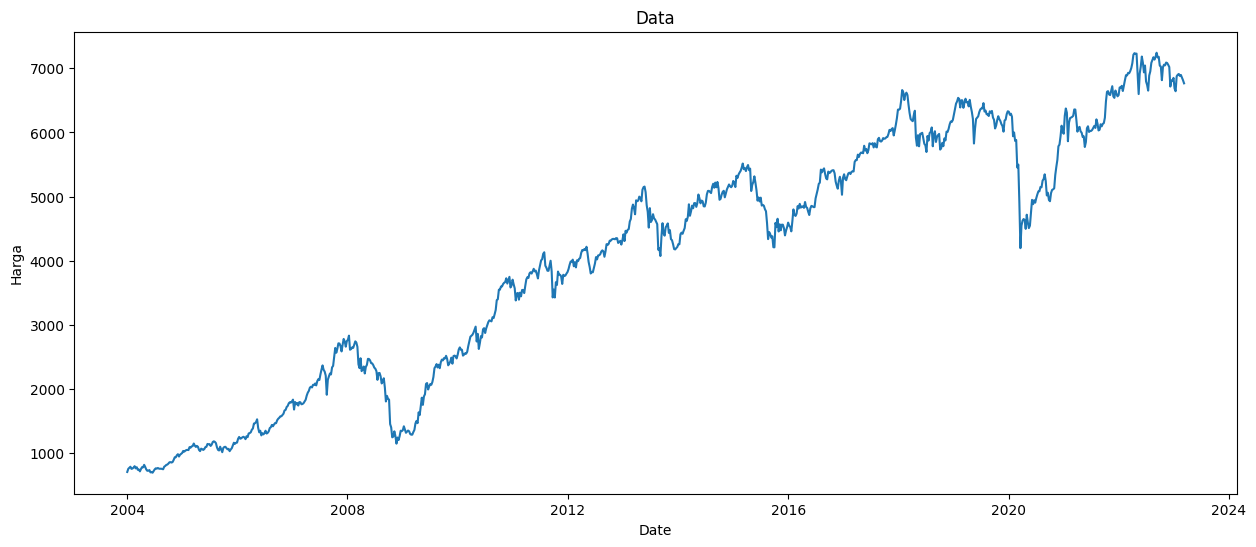

In [ ]:
plt.subplots(figsize = (15,6))
sns.lineplot(x="Date", y="Harga",
             data=raw_dataset)
plt.title("Data")

## Fill empty data with interpolate method

In [ ]:
dataset = pd.DataFrame(columns=['Date', 'Harga'])
dataset['Date'] = raw_dataset['Date']
dataset['Harga'] = raw_dataset['Harga'].interpolate(option='linear')
dataset

,Date,Harga
0,2004-01-02,704.497986
1,2004-01-09,753.692017
2,2004-01-16,770.333984
3,2004-01-23,785.879028
4,2004-01-30,752.932007
...,...,...
997,2023-02-10,6880.329102
998,2023-02-17,6895.713867
999,2023-02-24,6856.576172
1000,2023-03-03,6813.636230


In [ ]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1002 non-null   datetime64[ns]
 1   Harga   1002 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB
None


In [ ]:
dataset.describe()

,Harga
count,1002.000000
mean,4053.956414
std,1932.526005
min,692.715027
25%,2306.634460
50%,4450.690674
75%,5784.640137
max,7242.655762


## Splitting Data

In [ ]:
n_lookback = 5

In [ ]:
SPLIT_TIME_TRAIN_VAL = int(math.floor(0.70*((len(dataset))/n_lookback)) * n_lookback) 
SPLIT_TIME_TRAIN_VAL

700

In [ ]:
data_train = dataset[:SPLIT_TIME_TRAIN_VAL]['Harga']
data_train = pd.DataFrame(data_train)
data_train.index = dataset[:SPLIT_TIME_TRAIN_VAL]['Date']

data_val = dataset[SPLIT_TIME_TRAIN_VAL:]['Harga']
data_val = pd.DataFrame(data_val)
data_val.index = dataset[SPLIT_TIME_TRAIN_VAL:]['Date']

print(len(data_train)/len(dataset))
print(len(data_val)/len(dataset))


0.6986027944111777
0.3013972055888224


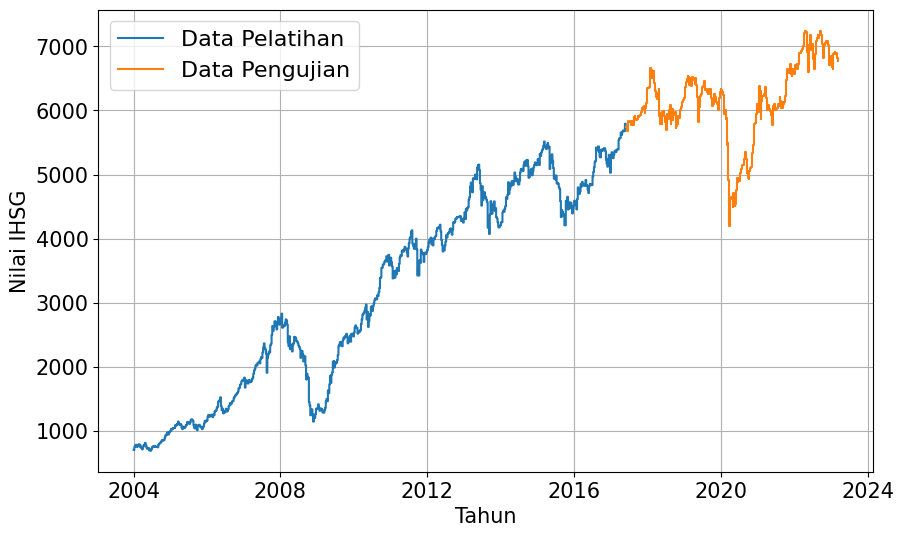

In [ ]:
plt.subplots(figsize = (10,6))
ax=sns.lineplot(x="Date", y="Harga",
             data=data_train, drawstyle='steps-post', label='Data Pelatihan')
ax=sns.lineplot(x="Date", y="Harga",
             data=data_val, drawstyle='steps-post', label='Data Pengujian')
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Tahun', fontsize=15); plt.ylabel('Nilai IHSG', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.grid()


In [ ]:
Harga = dataset["Harga"].values.reshape(-1, 1)

Harga_train = data_train.values.reshape(-1, 1)

Harga_val = data_val.values.reshape(-1, 1)

print(Harga_train.shape);print(Harga_val.shape)

(700, 1)
(302, 1)


In [ ]:
x_train = []
y_train = []

for i in range(n_lookback, len(Harga_train)):
    x_train.append(Harga_train[i - n_lookback: i])
    y_train.append(Harga_train[i])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(695, 5, 1)
(695, 1)


In [ ]:
x_val = []
y_val = []

for i in range(n_lookback, len(Harga_val)):
    x_val.append(Harga_val[i - n_lookback: i])
    y_val.append(Harga_val[i])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(297, 5, 1)
(297, 1)


## Scaling / Normalize Data

In [ ]:
Harga_scaled = normalize_series(Harga, Average(Harga), stdev(Harga.flatten()))

Harga_train_scaled = normalize_series(Harga_train, Average(Harga_train), stdev(Harga_train.flatten()))

Harga_val_scaled = normalize_series(Harga_val, Average(Harga_val), stdev(Harga_val.flatten()))


## Set feature and label period

In [ ]:
x_train_scaled = []
y_train_scaled = []

for i in range(n_lookback, len(Harga_train_scaled)):
    x_train_scaled.append(Harga_train_scaled[i - n_lookback: i])
    y_train_scaled.append(Harga_train_scaled[i])

x_train_scaled = np.array(x_train_scaled)
y_train_scaled = np.array(y_train_scaled)
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(695, 5, 1)
(695, 1)


In [ ]:
x_val_scaled = []
y_val_scaled = []

for i in range(n_lookback, len(Harga_val_scaled)):
    x_val_scaled.append(Harga_val_scaled[i - n_lookback: i])
    y_val_scaled.append(Harga_val_scaled[i])

x_val_scaled = np.array(x_val_scaled)
y_val_scaled = np.array(y_val_scaled)
print(x_val_scaled.shape)
print(y_val_scaled.shape)

(297, 5, 1)
(297, 1)


## generate model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

In [ ]:
#Model BiGRU
model = Sequential()
model.add(GRU(4,return_sequences=False,input_shape=(n_lookback,1),kernel_regularizer=l1_l2(l1=0.01, l2=0.5), activation='relu'))
model.add(Dense(1))
model.compile(loss='huber', optimizer=Adam(learning_rate=0.00005))

In [ ]:
# Define the filepath for saving the model weights
filepath = "best_model.h5"

# Create a ModelCheckpoint callback that saves the model weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min')

# Create an EarlyStopping callback that stops the training when the loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Fit the model to the data
history = model.fit(x_train_scaled, y_train_scaled, epochs=1000, validation_data=(x_val_scaled, y_val_scaled) ,batch_size=32,verbose=1, callbacks=[checkpoint, early_stopping])

Epoch 1/1000
22/22 [==============================] - 6s 21ms/step - loss: 1.1451 - val_loss: 1.1084
Epoch 2/1000
22/22 [==============================] - 0s 6ms/step - loss: 1.1389 - val_loss: 1.1027
Epoch 3/1000
22/22 [==============================] - 0s 8ms/step - loss: 1.1326 - val_loss: 1.0971
Epoch 4/1000
22/22 [==============================] - 0s 7ms/step - loss: 1.1265 - val_loss: 1.0915
Epoch 5/1000
22/22 [==============================] - 0s 6ms/step - loss: 1.1204 - val_loss: 1.0859
Epoch 6/1000
22/22 [==============================] - 0s 7ms/step - loss: 1.1143 - val_loss: 1.0804
Epoch 7/1000
22/22 [==============================] - 0s 9ms/step - loss: 1.1082 - val_loss: 1.0748
Epoch 8/1000
22/22 [==============================] - 0s 7ms/step - loss: 1.1022 - val_loss: 1.0693
Epoch 9/1000
22/22 [==============================] - 0s 6ms/step - loss: 1.0963 - val_loss: 1.0639
Epoch 10/1000
22/22 [==============================] - 0s 7ms/step - loss: 1.0903 - val_loss: 1.058

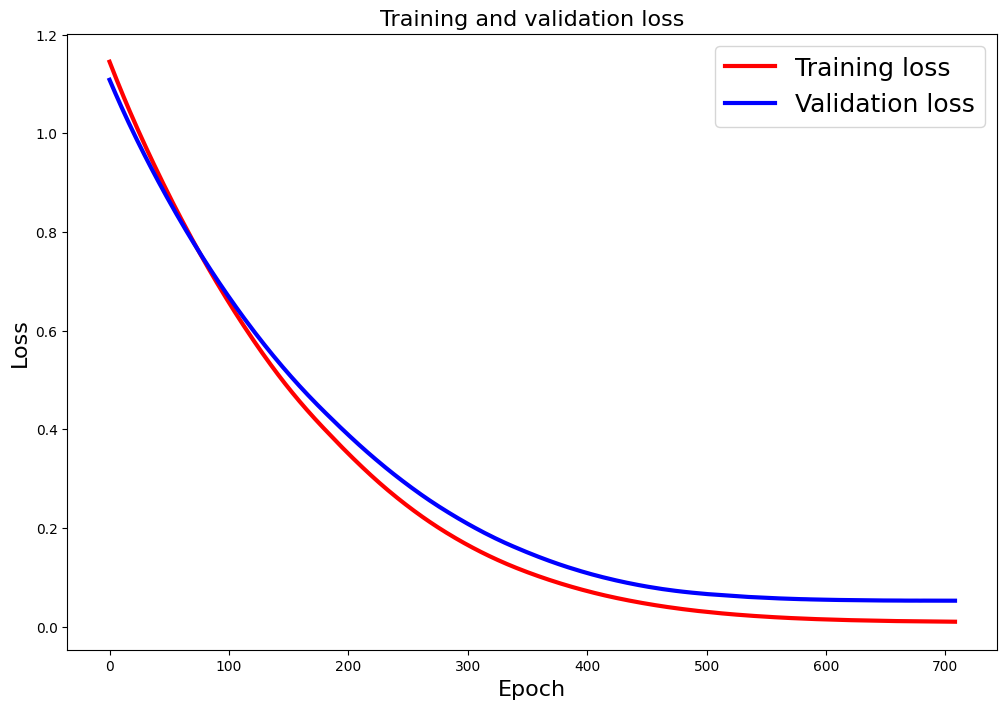

In [ ]:
#Loss Curve
plt.figure(figsize=[12,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss','Validation loss'],fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training and validation loss',fontsize=16)
plt.show()


## Prediction

### Prediction with training data

In [ ]:
forecast_train_data = model_forecast(model, Harga_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(Harga_train_scaled.shape[0]-n_lookback)

696/696 [==============================] - 1s 2ms/step
(696, 1)
(695,)
695


In [ ]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(Harga_train), stdev(Harga_train.flatten()))
forecast_train_data[:5]


array([825.74975944, 834.98706412, 837.38208365, 841.03296256,
       838.67969108])

In [ ]:
actual = np.squeeze(Harga_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(695,)
[758.924011 773.140015 794.46698  761.080994 778.01001 ]


In [ ]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

,Date,Actual,Forecast
0,2004-02-06,758.924011,825.749759
1,2004-02-13,773.140015,834.987064
2,2004-02-20,794.466980,837.382084
3,2004-02-27,761.080994,841.032963
4,2004-03-05,778.010010,838.679691
...,...,...,...
690,2017-04-28,5685.297852,5606.590091
691,2017-05-05,5683.376953,5629.974857
692,2017-05-12,5675.215820,5645.748539
693,2017-05-19,5791.883789,5648.618900


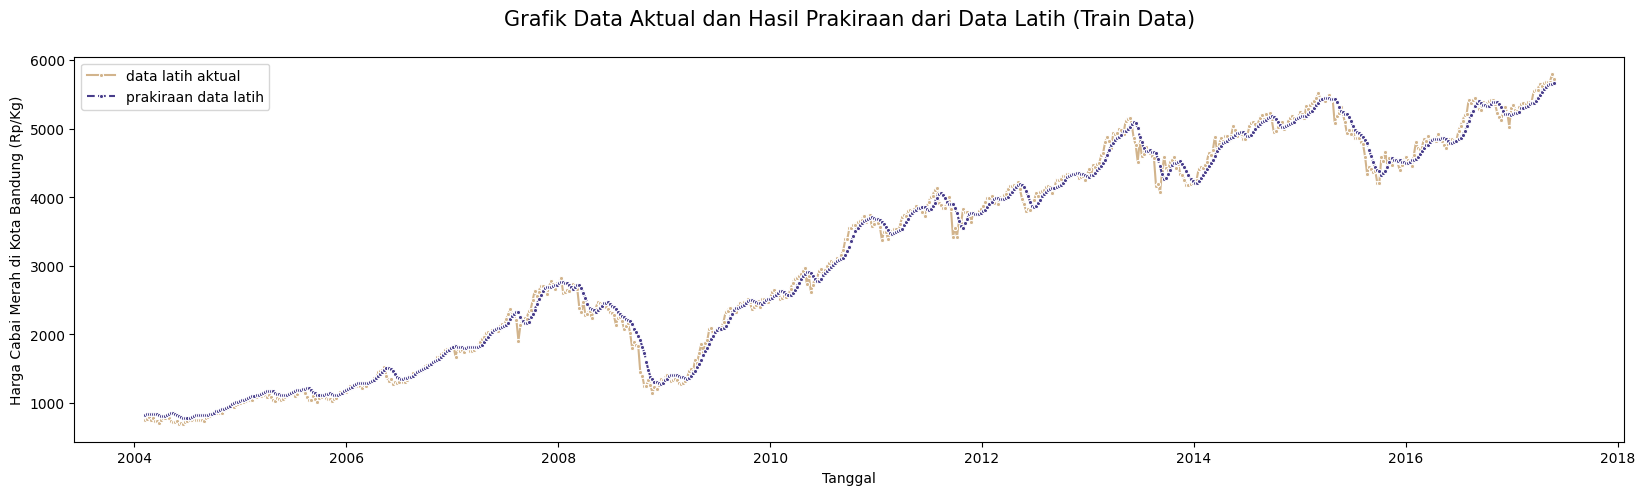

In [ ]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Harga Cabai Merah di Kota Bandung (Rp/Kg)')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [ ]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

Forecast Train accuracy
RMSE:  118.6783
MAE:  87.1413
MAPE:  0.033572


### Prediction with validation data

In [ ]:
forecast_val_data = model_forecast(model, Harga_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(Harga_val_scaled.shape[0]-n_lookback)

298/298 [==============================] - 1s 2ms/step
(298, 1)
(297,)
297


In [ ]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(Harga_val), stdev(Harga_val.flatten()))
forecast_val_data[:5]

array([5769.55064243, 5789.09654087, 5819.38798374, 5826.96287388,
       5824.92475742])

In [ ]:
actual = np.squeeze(Harga_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(297,)
[5814.792969 5831.794922 5765.423828 5831.026855 5777.481934]


In [ ]:
len(data_val[-forecast_val_data.shape[0]:])

297

In [ ]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

,Date,Actual,Forecast
0,2017-07-07,5814.792969,5769.550642
1,2017-07-14,5831.794922,5789.096541
2,2017-07-21,5765.423828,5819.387984
3,2017-07-28,5831.026855,5826.962874
4,2017-08-04,5777.481934,5824.924757
...,...,...,...
292,2023-02-10,6880.329102,6804.680495
293,2023-02-17,6895.713867,6849.927443
294,2023-02-24,6856.576172,6894.083937
295,2023-03-03,6813.636230,6890.618239


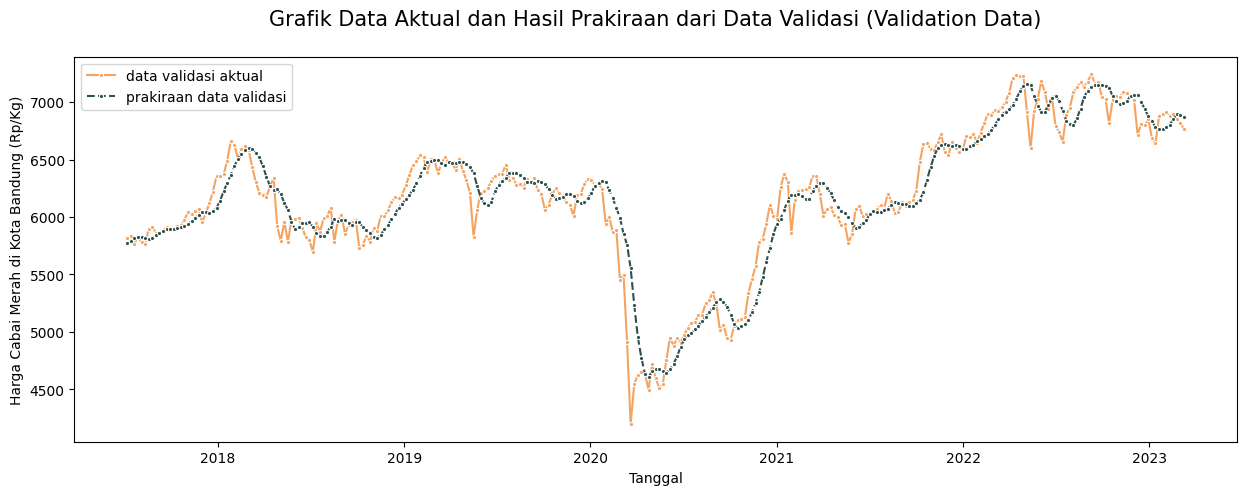

In [ ]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Harga Cabai Merah di Kota Bandung (Rp/Kg)')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [ ]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

Forecast Val accuracy
RMSE:  188.6422
MAE:  131.0222
MAPE:  0.02162


## Summary Eval Metric

In [ ]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

Forecast Train accuracy
RMSE:  118.6783
MAE:  87.1413
MAPE:  0.033572
Forecast Val accuracy
RMSE:  188.6422
MAE:  131.0222
MAPE:  0.02162


## Forecast Future Values

In [ ]:
# forecast the next 10 period
forecast_values = multi_step_forecasts(n_lookback=n_lookback, n_forecast=8, model=model, data=Harga, data_scaled=Harga_scaled)

1/1 [==============================] - 0s 21ms/step


In [ ]:
date_forecast = [dt.strftime('%Y-%m-%d') for dt in 
       datetime_range(datetime(2023, 3, 17), datetime(2023, 5, 6), 
       relativedelta(weeks=1))]

print(np.shape(date_forecast))

(8,)


In [ ]:
df_forecast = pd.DataFrame(columns=['Date', 'Forecast'])
df_forecast['Date'] = date_forecast
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast['Forecast'] = np.squeeze(forecast_values)
df_forecast

,Date,Forecast
0,2023-03-17,6840.290643
1,2023-03-24,6827.286004
2,2023-03-31,6814.192254
3,2023-04-07,6808.539422
4,2023-04-14,6809.544793
5,2023-04-21,6815.681512
6,2023-04-28,6810.635858
7,2023-05-05,6807.871698


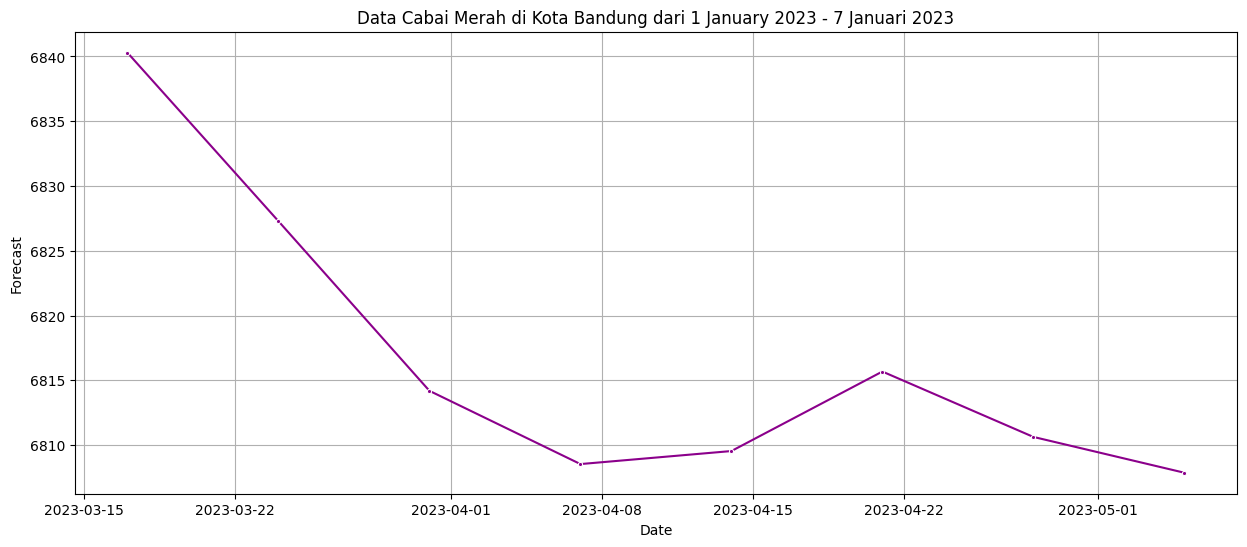

In [ ]:
from turtle import color

plt.subplots(figsize = (15,6))
sns.lineplot(x="Date", y="Forecast",
             data=df_forecast, marker='.', color = 'darkmagenta')
plt.title("Data Cabai Merah di Kota Bandung dari 1 January 2023 - 7 Januari 2023")
plt.grid()

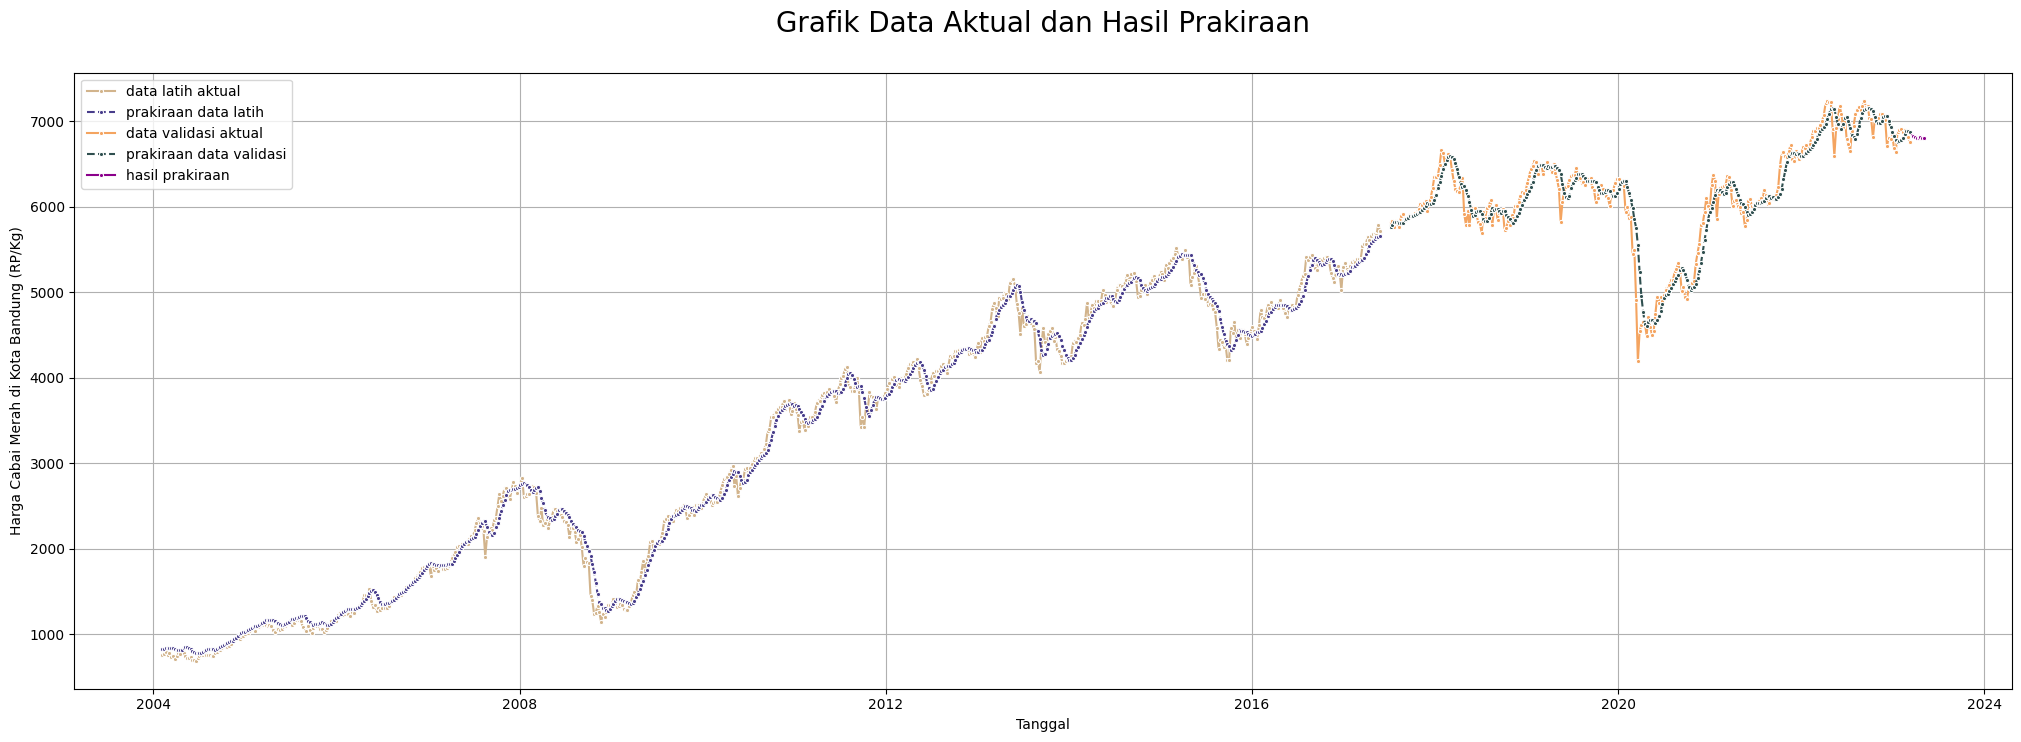

In [ ]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast,
                    label="hasil prakiraan", marker='.', color = 'darkmagenta')
plt.grid()
plt.xlabel('Tanggal'); plt.ylabel('Harga Cabai Merah di Kota Bandung (RP/Kg)')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

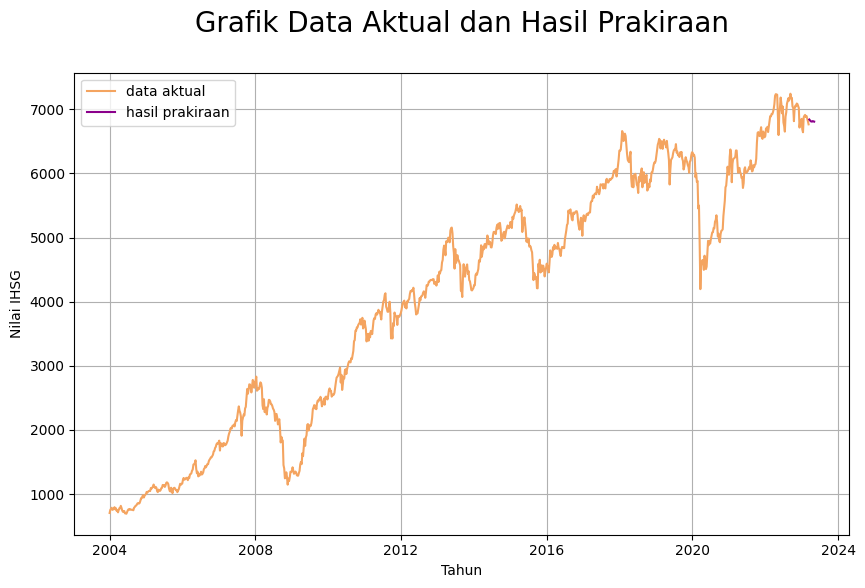

In [ ]:
fig, ax = plt.subplots(figsize = (10,6)) 
ax = sns.lineplot(x="Date", y="Harga", data=dataset, 
                    label="data aktual", color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="hasil prakiraan", color='darkmagenta')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.xlabel('Tahun'); plt.ylabel('Nilai IHSG')
plt.grid()

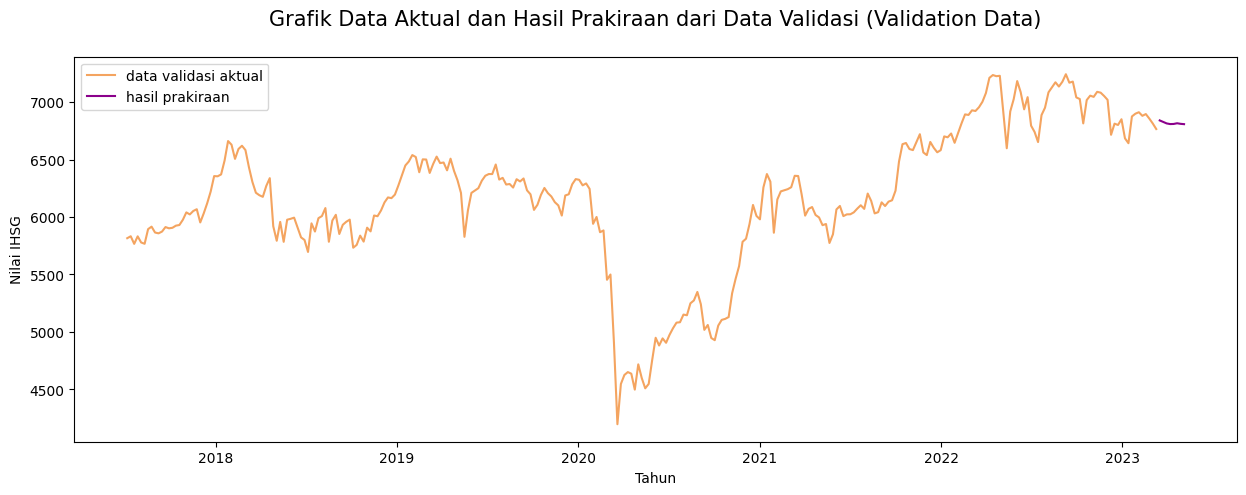

In [ ]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="hasil prakiraan", color='darkmagenta')
plt.xlabel('Tahun'); plt.ylabel('Nilai IHSG')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')